In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad

from bin import utils
from tqdm import tqdm

In [2]:
fdata = sc.read_h5ad('./RNA/Multitime.clustered.h5')
gdata = sc.read_h5ad('./RNA/Multitime.filterguide.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './RNA/Multitime.filterguide.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [9]:
fdata, gdata = utils.align_rna_guide_data(fdata, gdata)

In [10]:
cdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240502-SPACseq/bin/utils.py:88: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [18]:
fdata_list = [fdata[fdata.obs.marker == marker].copy() for marker in fdata.obs.marker.unique()]
gdata_list = [gdata[gdata.obs.marker == marker].copy() for marker in gdata.obs.marker.unique()]

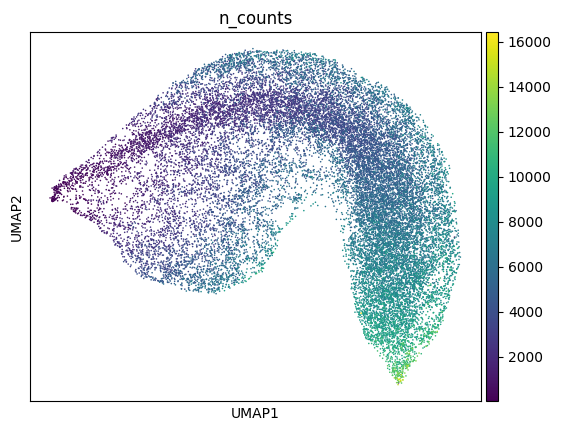

In [24]:
sc.pp.pca(fdata_list[2])

In [50]:
sc.pp.highly_variable_genes(fdata_list[2], n_top_genes=500, n_bins=50, subset=False, inplace=True)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: RuntimeWarning: invalid value encountered in divide
  df["dispersions_norm"] = (


In [51]:
hv_data = fdata_list[2][:, fdata_list[2].var.highly_variable]

In [ ]:
sc.pp.pca(hv_data)

In [65]:
sc.pp.neighbors(hv_data, n_neighbors=5, n_pcs=10)
sc.tl.umap(hv_data)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


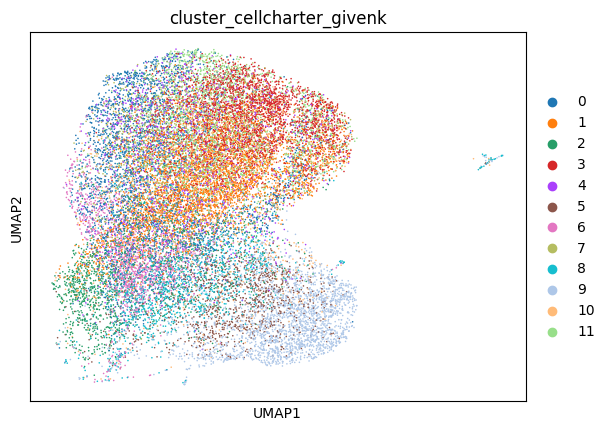

In [66]:
sc.pl.umap(hv_data, color='cluster_cellcharter_givenk')

In [70]:
gdata_list[2].obsm['X_umap'] = hv_data.obsm['X_umap']

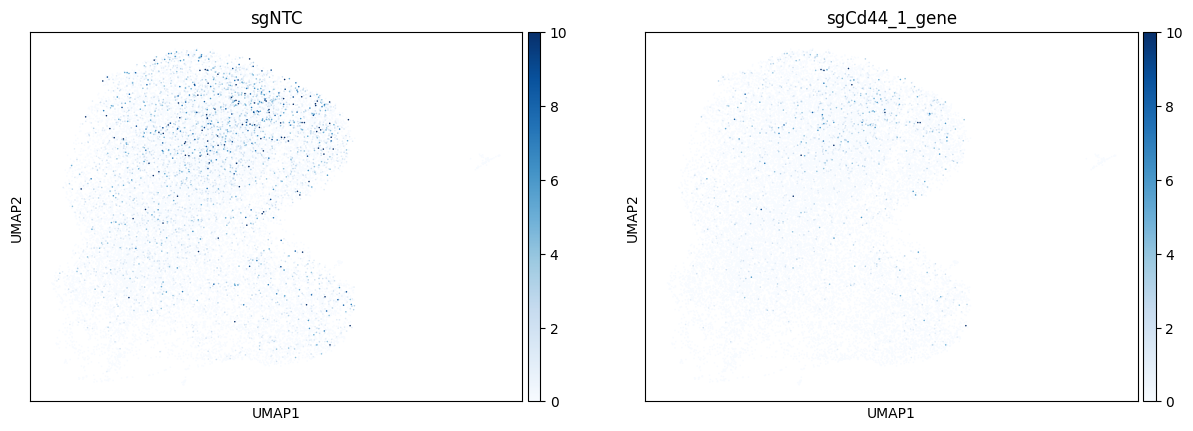

In [83]:
sc.pl.umap(gdata_list[2], color=['sgNTC', 'sgCd44_1_gene'], size=5, vmax=10, cmap='Blues')

In [123]:
guide_dist = {}
guide_points = {}
ntc_point = np.sum([a*b for a, b in zip(gdata_list[2][gdata_list[2][:, 'sgNTC'].X > 0].obsm['X_umap'], gdata_list[2][gdata_list[2][:, 'sgNTC'].X > 0, 'sgNTC'].X.toarray())], axis=0) \
    / np.sum(gdata_list[2][:, 'sgNTC'].X)
for guide in gdata_list[2].var_names:
    if guide == 'sgNTC': continue
    guide_point = np.sum([a*b for a, b in zip(gdata_list[2][gdata_list[2][:, guide].X > 0].obsm['X_umap'],
        gdata_list[2][gdata_list[2][:, guide].X > 0, guide].X.toarray())], axis=0) \
        / np.sum(gdata_list[2][:, guide].X)
    guide_points[guide] = guide_point
    guide_dist[guide] = np.sqrt((ntc_point[0] - guide_point[0]) ** 2 + (ntc_point[1] - guide_point[1]) ** 2)

In [118]:
d_df = pd.DataFrame(guide_dist, index=['distance']).T.sort_values(by='distance')

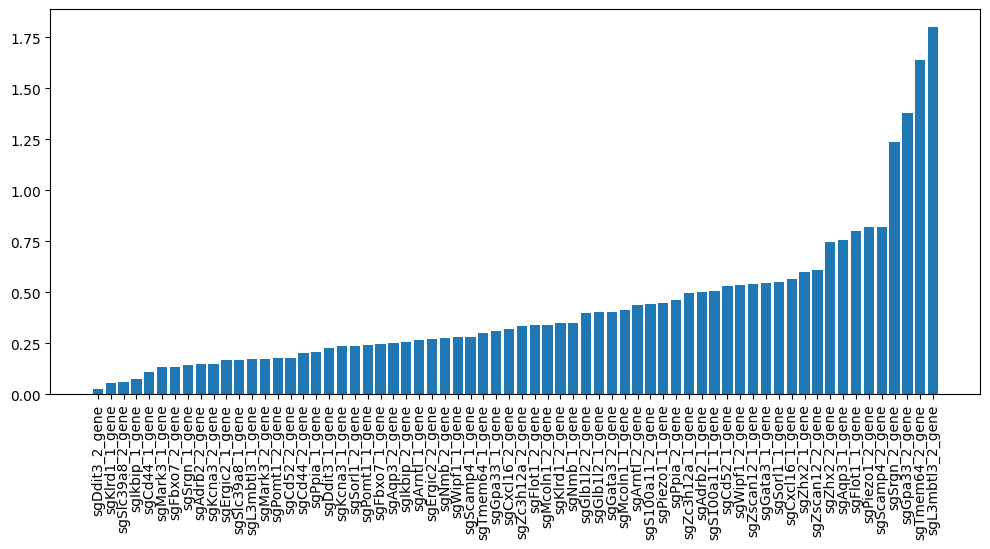

In [122]:
plt.figure(figsize=(12, 5))
plt.bar(d_df.index, d_df.distance)
plt.xticks(rotation=90)
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


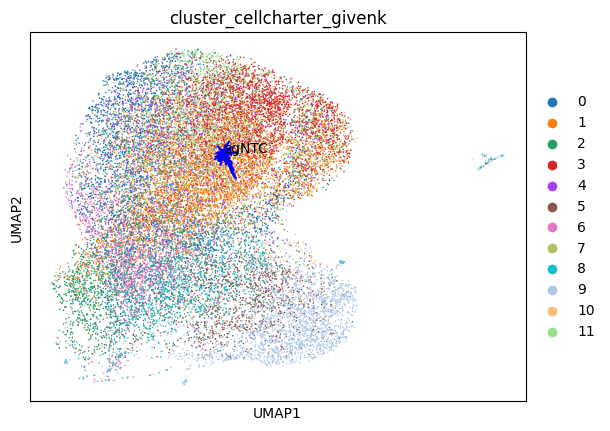

In [150]:
fig, ax = plt.subplots(1, 1)
sc.pl.umap(hv_data, color=['cluster_cellcharter_givenk'], size=5, ax=ax, show=False)
for guide in gdata_list[2].var_names:
    if guide == 'sgNTC': continue
    ax.plot([ntc_point[0], guide_points[guide][0]], [ntc_point[1], guide_points[guide][1]], color='blue')
    #ax.text(guide_points[guide][0], guide_points[guide][1], guide.split('_')[0])
ax.text(ntc_point[0], ntc_point[1], 'sgNTC')
plt.show()